# Direct Target Marketing

mass marketing sees all customers as one unit. One-to-one marketing focuses on one customer at a time. Direct target marketing lies between mass marketing and one-to-one marketing. Direct target marketing involves activities to those customers who are most likely to buy the product. 

Direct target marketing implies selection. Some customers are identified as more valuable than others and these more valued customers are given special attention. 

By using direct target marketing properly, companies can improve its profitability, increasing revenues and decreasing costs. 

Models for direct marketing: Bank Casework

- What do we mean by a direct marketing model? Classification into likely buyers vs. non-buyers 

- Shall we have one model or many (one for each segment or one for each mailing)?

- Define a meaningful response and a set of legitimate explanatory variables (no independent/dependent variable confounding)

- Training/test approach to model testing: Do explonatory analysis and data preparation on the training set alone. Develop targeting model (model specification and subset selection) on the training set alone.

- Evaluate the model on the test set using statistical and financial evaluation criteria

- Develop specific recommendations for management - which customers should be sent mailings (likely buyers predicted by the model)?

- What's the profit contribution of the model? Without the model, we mail to everyone. With the model we mail only to predicted likely buyers. Using the test set predict costs and sales with and without using the model for targeting. 

### Project workspace setup

In [1]:
# Python >= 3.7
import sys

# Scikit-Learn >= 0.22
import sklearn

# Common import packages for text processing and machine learning
import numpy as np # arrays and numerical processing
import pandas as pd # DataFrame structure and operations
import os

# Making the notebook's output stable across runs
np.random.seed(31)

# To plot figures
%matplotlib inline
import matplotlib as mp
import matplotlib.pyplot as plt # 2D plotting
mp.rc('axes', labelsize=14)
mp.rc('xtick', labelsize=12)
mp.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_DIR = "."
SECTION_ID = "targeting_customers"
IMAGES_PATH = os.path.join(PROJECT_DIR, "images", SECTION_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_img(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving image", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Get the data

In [2]:
bankData = pd.read_csv('datasets/bank.csv', sep=';')

In [3]:
print(bankData.head())

   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome response  
0  cellular   19   oct        79         1     -1         0  unknown       no  
1  cellular   11   may       220         1    339         4  failure       no  
2  cellular   16   apr       185         1    330         1  failure       no  
3   unknown    3   jun       199         4     -1         0  unknown       no  
4   unknown    5   may       226         1     -1         0  unknown       no  


### Defining parameters
We need to identify parameters that are useful and determine how to use those parameters in our models.
A response parameter is something we would like to predict, or whether a customer would buy a product. 
Customer lifetime value is a multiple response parameter, calculated from many transactions with each customer, and these transactions include observations of sales and costs.

In [4]:
jobtitle = {'admin.': 'White Collar', 'entrepreneur': 'White Collar', 'management': 'White Collar',
          'self-employed': 'White Collar', 'blue-collar': 'Blue Collar', 'services': 'Blue Collar',
          'technician': 'Blue Collar'}
marital_status = {'divorced': 'Divorced', 'married': 'Married', 'single': 'Single'}
education_level = {'primary': 'Primary', 'secondary': 'Secondary', 'tertiary': 'Tertiary'}
yesno = {'yes': 1, 'no': 0}

# jobtype 
bankData['jobtype'] = bankData['job'].map(jobtitle)
bankData['jobtype'] = bankData['jobtype'].fillna('Other')

# marital status
bankData['marital'] = bankData['marital'].map(marital_status)
bankData['marital'] = bankData['marital'].fillna('Unknown')

# education
bankData['education'] = bankData['education'].map(education_level)
bankData['education'] = bankData['education'].fillna('Unknown')

# default
bankData['default'] = bankData['default'].map(yesno)
bankData['default'] = bankData['default'].fillna('No')

# housing
bankData['housing'] = bankData['housing'].map(yesno)
bankData['housing'] = bankData['housing'].fillna('No')

# loan
bankData['loan'] = bankData['loan'].map(yesno)
bankData['loan'] = bankData['loan'].fillna('No')

# response
bankData['response'] = bankData['response'].map(yesno)
bankData['response'] = bankData['response'].fillna('No')

In [5]:
# selecting the subset of customers who are approached for the first time. 
# Part of the goal of direct target marketing is to deal with low response rates and promotional efforts. 

first_time_customers = bankData['pdays'].map(lambda x: x == -1)

first_time_bankData = pd.DataFrame(bankData[first_time_customers], columns = [
    'response', 'age', 'jobtype', 'education', 'marital', 'default', 'balance', 'housing', 'loan'])

In [6]:
print(first_time_bankData.head())

   response  age       jobtype  education  marital  default  balance  housing  \
0         0   30         Other    Primary  Married        0     1787        0   
3         0   30  White Collar   Tertiary  Married        0     1476        1   
4         0   59   Blue Collar  Secondary  Married        0        0        1   
7         0   39   Blue Collar  Secondary  Married        0      147        1   
8         0   41  White Collar   Tertiary  Married        0      221        1   

   loan  
0     0  
3     1  
4     0  
7     0  
8     0  


In [7]:
print(first_time_bankData.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3705 entries, 0 to 4518
Data columns (total 9 columns):
response     3705 non-null int64
age          3705 non-null int64
jobtype      3705 non-null object
education    3705 non-null object
marital      3705 non-null object
default      3705 non-null int64
balance      3705 non-null int64
housing      3705 non-null int64
loan         3705 non-null int64
dtypes: int64(6), object(3)
memory usage: 289.5+ KB
None


In [8]:
print(first_time_bankData.describe())

          response          age      default       balance      housing  \
count  3705.000000  3705.000000  3705.000000   3705.000000  3705.000000   
mean      0.090958    41.083671     0.019163   1374.862078     0.551417   
std       0.287588    10.373818     0.137117   3008.524207     0.497416   
min       0.000000    19.000000     0.000000  -3313.000000     0.000000   
25%       0.000000    33.000000     0.000000     60.000000     0.000000   
50%       0.000000    39.000000     0.000000    415.000000     1.000000   
75%       0.000000    49.000000     0.000000   1412.000000     1.000000   
max       1.000000    87.000000     1.000000  71188.000000     1.000000   

              loan  
count  3705.000000  
mean      0.159784  
std       0.366455  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000  


In [9]:
# examining baseline response rate
accepted_offer = first_time_bankData['response'].map(lambda x: x == 1)
baseline = len(first_time_bankData[accepted_offer]) / len(first_time_bankData)
print('Proportion of bank customers responding to offer: ', round(baseline, 5), '\n')

Proportion of bank customers responding to offer:  0.09096 



### Variables of interest
Parameters are used to predict response parameters. Parameters can be continous, having meaningful magnitude or categorical, without meaningful magnitude. 

Common parameters of interst in business-to-consumer marketing involve demographics, behavioral, and lifestyle parameters. In business-to-business marketing, parameters of interest include the business, industry sector, and the geographic location. In either case, parameters of interst can come from anything that we know about the customers, including past transactions and support history with customers. 

In [10]:
# average continous parameters by response. When the response parameter is continous, 
# we use regression to make the prediction

print(first_time_bankData.pivot_table(['age'], index = ['response']))
print(first_time_bankData.pivot_table(['balance'], index = ['response']))

                age
response           
0         40.983076
1         42.089021
              balance
response             
0         1359.654097
1         1526.851632


In [11]:
# examining categorical parameters by response. When the response parameter is categorical,
# we use classification.

print(first_time_bankData.pivot_table(['response'], index = ['jobtype']))
print(first_time_bankData.pivot_table(['response'], index = ['education']))
print(first_time_bankData.pivot_table(['response'], index = ['marital']))
print(first_time_bankData.pivot_table(['response'], index = ['default']))
print(first_time_bankData.pivot_table(['response'], index = ['housing']))
print(first_time_bankData.pivot_table(['response'], index = ['loan']))

              response
jobtype               
Blue Collar   0.072072
Other         0.144958
White Collar  0.096352
           response
education          
Primary    0.082759
Secondary  0.082496
Tertiary   0.112546
Unknown    0.073333
          response
marital           
Divorced  0.126411
Married   0.073753
Single    0.115987
         response
default          
0        0.090534
1        0.112676
         response
housing          
0        0.116727
1        0.069995
      response
loan          
0     0.098619
1     0.050676


In [12]:
print(first_time_bankData.head())

   response  age       jobtype  education  marital  default  balance  housing  \
0         0   30         Other    Primary  Married        0     1787        0   
3         0   30  White Collar   Tertiary  Married        0     1476        1   
4         0   59   Blue Collar  Secondary  Married        0        0        1   
7         0   39   Blue Collar  Secondary  Married        0      147        1   
8         0   41  White Collar   Tertiary  Married        0      221        1   

   loan  
0     0  
3     1  
4     0  
7     0  
8     0  


Saving image attribute_histogram_plots


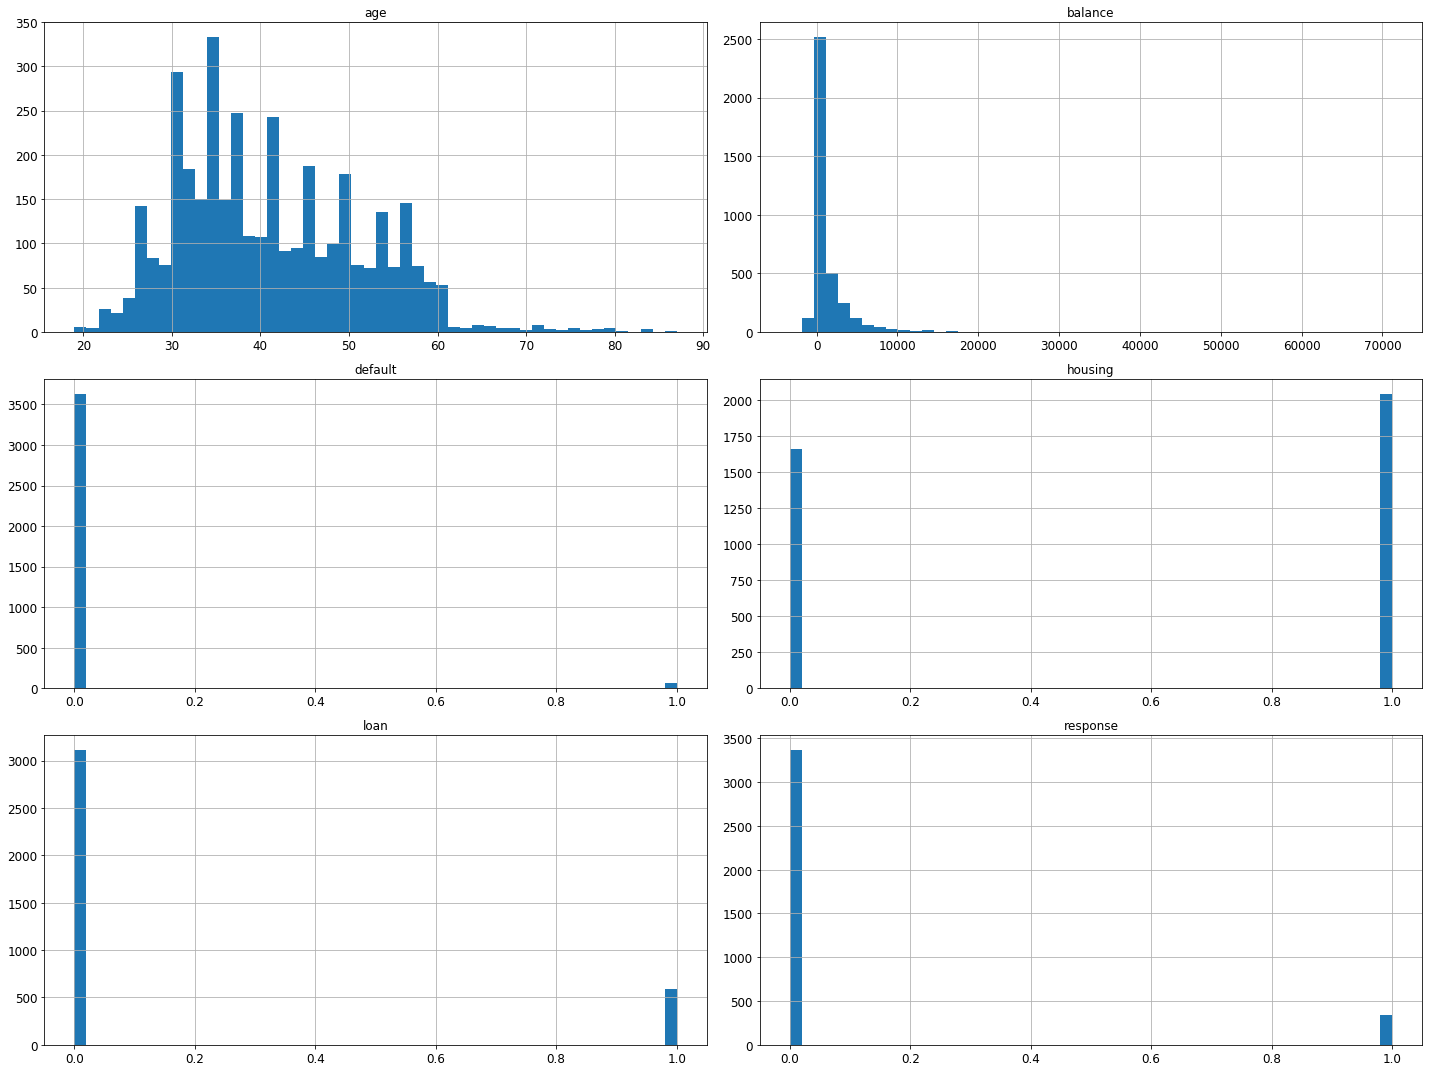

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
first_time_bankData.hist(bins=50, figsize=(20, 15))
save_img("attribute_histogram_plots")
plt.show()

In [14]:
import patsy
import statsmodels.api as sm
import statsmodels.formula as smf
# matrix for statsmodels
bank_logit = 'response ~ age + jobtype + education + marital + default + balance + housing + loan'
y, x = patsy.dmatrices(bank_logit, first_time_bankData, return_type = 'dataframe')

In [15]:
bank_logit_model = sm.Logit(y, x)
bank_logit_fit = bank_logit_model.fit()
print(bank_logit_fit.summary())

Optimization terminated successfully.
         Current function value: 0.293877
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               response   No. Observations:                 3705
Model:                          Logit   Df Residuals:                     3692
Method:                           MLE   Df Model:                           12
Date:                Fri, 16 Aug 2019   Pseudo R-squ.:                 0.03568
Time:                        17:49:14   Log-Likelihood:                -1088.8
converged:                       True   LL-Null:                       -1129.1
Covariance Type:            nonrobust   LLR p-value:                 3.223e-12
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.3937      0.390     -6.132      0.000      -3.159   

In [16]:
# Prediction probability offer
first_time_bankData['prediction_logit_prob'] = bank_logit_fit.predict(linear = False)

In [17]:
# map probability cutoff
def prediction_prob(x, cutoff):
    if x > cutoff:
        return 1
    else:
        return 0

In [21]:
# using 10 percent response cutoff
first_time_bankData['prediction_10'] = \
first_time_bankData['prediction_logit_prob'].apply(lambda x: prediction_prob(x, cutoff=0.10))
print('Confusion matrix for 0.10 cutoff\n',
     pd.crosstab(first_time_bankData.prediction_10, first_time_bankData.response, margins=True))

Confusion matrix for 0.10 cutoff
 response          0    1   All
prediction_10                 
0              2262  159  2421
1              1106  178  1284
All            3368  337  3705


In [22]:
# calculation of lift
label = []
for i in range(10):
    label.append('Label_'+str(10 - i))
    
def lift(x):
    return(x / baseline)

In [24]:
predictions = pd.qcut(first_time_bankData.prediction_logit_prob, 10, labels = label)
label_groups = first_time_bankData.response.groupby(predictions)
print(label_groups.mean())

prediction_logit_prob
Label_10    0.043127
Label_9     0.048649
Label_8     0.053908
Label_7     0.072973
Label_6     0.078167
Label_5     0.078378
Label_4     0.110811
Label_3     0.118598
Label_2     0.102703
Label_1     0.202156
Name: response, dtype: float64


In [25]:
lift_values = label_groups.mean() / baseline
print('Lift Chart Values by Label:\n', lift_values, '\n')

Lift Chart Values by Label:
 prediction_logit_prob
Label_10    0.474138
Label_9     0.534846
Label_8     0.592672
Label_7     0.802270
Label_6     0.859374
Label_5     0.861697
Label_4     1.218261
Label_3     1.303878
Label_2     1.129120
Label_1     2.222520
Name: response, dtype: float64 

